# Prepare 3DEP reference elevations

In [1]:
import os
import geopandas as gpd
import pandas as pd
import xdem
import glob
from shapely.geometry import Polygon
import shutil
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import subprocess

/Users/raineyaberle/opt/anaconda3/envs/skysat_stereo_snow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 68/68 [01:12<00:00,  1.06s/it]


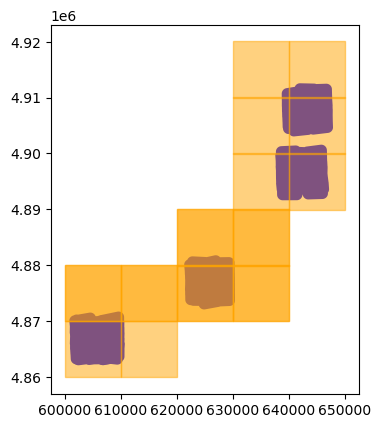

20 3DEP DEMs intersect SkySat footprints. Copied to separate folder: /Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/USGS_3DEP/DEMs_filtered


In [2]:
data_dir = '/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo'
dem_filt_dir = os.path.join(data_dir, 'USGS_3DEP', 'DEMs_filtered')
if not os.path.exists(dem_filt_dir):
    os.mkdir(dem_filt_dir)

# load SkySat image bounds
site_names = ['Banner', 'JacksonPeak', 'MCS']
extents = gpd.GeoDataFrame()
for site_name in site_names:
    dates = glob.glob(os.path.join(data_dir, 'study-sites', site_name, '20*'))
    dates = [os.path.basename(date) for date in dates]
    for date in dates:
        extent_fn = glob.glob(os.path.join(data_dir, 'study-sites', site_name, date, 'SkySatScene', '*extent.gpkg'))[0]
        extent = gpd.read_file(extent_fn)
        extents = pd.concat([extents, extent])
extents.reset_index(drop=True, inplace=True)
# buffer each by 1 km
extents['geometry'] = [x.buffer(1e3) for x in extents['geometry']]

# set up plot
fig, ax = plt.subplots()
extents.plot(ax=ax, color='b')

# Identify DEMs that intersect with buffered SkySat image bounds
dem_fns = sorted(glob.glob(os.path.join(data_dir, 'USGS_3DEP', '*.tif')))
n = 0
# iterate over DEM file names
for dem_fn in tqdm(dem_fns):
    dem = xdem.DEM(dem_fn)#.reproject(crs=f"EPSG:{extents.crs.to_epsg()}")
    bounds = dem.bounds
    poly = Polygon([[bounds.left, bounds.bottom], [bounds.right, bounds.bottom],
                    [bounds.right, bounds.top], [bounds.left, bounds.top], [bounds.left, bounds.bottom]])
    # check if it intersects SkySat image bounds
    if any(poly.intersects(extents['geometry'].values)):
        shutil.copy2(dem_fn, os.path.join(dem_filt_dir, os.path.basename(dem_fn)))
        ax.fill(*poly.exterior.coords.xy, color='orange', alpha=0.5)
        n += 1

plt.show()
print(f"{n} 3DEP DEMs intersect SkySat footprints. Copied to separate folder:", dem_filt_dir)


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [01:01<00:00,  3.06s/it]


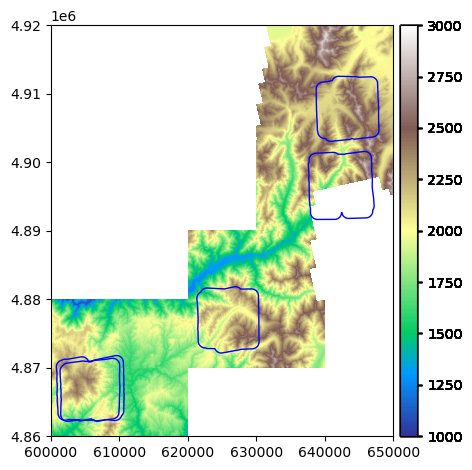

In [6]:
dem_filt_fns = sorted(glob.glob(os.path.join(dem_filt_dir, '*.tif')))

fig, ax = plt.subplots()
for dem_fn in tqdm(dem_filt_fns):
    dem = xdem.DEM(dem_fn).reproject(res=10)
    dem.plot(ax=ax, cmap='terrain', vmin=1000, vmax=3000)

extents.plot(ax=ax, facecolor='None', edgecolor='b')
plt.show()

In [7]:
# Mosaic all filtered DEMs
cmd = ['gdal_merge'] + dem_filt_fns + ['-o', os.path.join(dem_filt_dir, 'USGS_3DEP_DEMs_mosaic.tif')]
subprocess.run(cmd)

ModuleNotFoundError: No module named 'numpy'
Warning 1: PROJ: proj_create_from_database: /Users/raineyaberle/opt/anaconda3/envs/skysat_stereo_snow/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 5 is expected. It comes from another PROJ installation.
Warning 1: The definition of projected CRS EPSG:26911 got from GeoTIFF keys is not the same as the one from the EPSG registry, which may cause issues during reprojection operations. Set GTIFF_SRS_SOURCE configuration option to EPSG to use official parameters (overriding the ones from GeoTIFF keys), or to GEOKEYS to use custom values from GeoTIFF keys and drop the EPSG code.
Warning 1: PROJ: proj_create_from_database: /Users/raineyaberle/opt/anaconda3/envs/skysat_stereo_snow/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 5 is expected. It comes from another PROJ installation.
Warning 1: The definition of projected CRS EPSG:26911 got from GeoTIFF keys is not the same as the

0

ERROR 1: PROJ: proj_create_from_name: /Users/raineyaberle/opt/anaconda3/envs/skysat_stereo_snow/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 5 is expected. It comes from another PROJ installation.


CompletedProcess(args=['gdal_merge', '/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/USGS_3DEP/DEMs_filtered/USGS_1M_11_x60y488_ID_SouthernID_2018_D19.tif', '/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/USGS_3DEP/DEMs_filtered/USGS_1M_11_x61y488_ID_SouthernID_2018_D19.tif', '/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/USGS_3DEP/DEMs_filtered/USGS_1M_11_x62y488_ID_SouthernID_2018_D19.tif', '/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/USGS_3DEP/DEMs_filtered/USGS_1M_11_x62y489_ID_SouthernID_2018_D19.tif', '/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/USGS_3DEP/DEMs_filtered/USGS_1M_11_x63y488_ID_SouthernID_2018_D19.tif', '/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/USGS_3DEP/DEMs_filtered/USGS_1M_11_x63y489_ID_SouthernID_2018_D19.tif', '/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/USGS_3DEP/DEMs_filtered/USGS_1M_11_x63y490_ID_SouthernID_2018_D19.tif', '/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/USGS_3DEP/D